# Prueba del grafo

In [1]:
# langgraph_monkey_agent.py
from __future__ import annotations
from typing import TypedDict, Annotated, Optional, Sequence, Literal, Any, Dict, List, Tuple
import io
from PIL import Image

# LangGraph / LangChain
try:
    from langgraph.graph import StateGraph, START, END
    from langgraph.graph.message import add_messages
    from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
except Exception:
    # Stubs para que el archivo importe sin libs (no ejecutará el grafo)
    def add_messages(x, y): return (x or []) + (y or [])
    class AnyMessage: ...
    class HumanMessage:
        def __init__(self, content): self.content = content
    class AIMessage:
        def __init__(self, content): self.content = content
    StateGraph = START = END = object

# --------------------------------------------------------------------------------------
# 0) Estado mínimo + current_taxon
# --------------------------------------------------------------------------------------
class ChatVisionState(TypedDict, total=False):
    messages: Annotated[Sequence[AnyMessage], add_messages]
    image_bytes: Optional[bytes]
    image_url:   Optional[str]
    topk: int
    accept_policy: Literal["entropy", "confidence", "margin"]
    accept_threshold: float
    current_taxon: Optional[str]

# --------------------------------------------------------------------------------------
# 1) Mapping label -> nombre científico (binomio)
# --------------------------------------------------------------------------------------
LABEL_TO_LATIN: Dict[str, str] = {
    "Mantled_howler": "Alouatta palliata",
    "Patas_monkey": "Erythrocebus patas",
    "Bald_uakari": "Cacajao calvus",
    "Japanese_macaque": "Macaca fuscata",
    "Pygmy_marmoset": "Cebuella pygmaea",
    "White_headed_capuchin": "Cebus capucinus",
    "Silvery_marmoset": "Mico argentatus",
    "Common_squirrel_monkey": "Saimiri sciureus",   # normalizado sin espacio
    "Black_headed_night_monkey": "Aotus nigriceps",
    "Nilgiri_langur": "Semnopithecus johnii",
}

# --------------------------------------------------------------------------------------
# 2) Helpers
# --------------------------------------------------------------------------------------
def has_image(state: ChatVisionState) -> bool:
    return bool(state.get("image_bytes") or state.get("image_url"))

def last_user_utterance(state: ChatVisionState) -> str:
    # Simple: toma el último mensaje humano del historial
    for msg in reversed(state.get("messages", [])):
        if isinstance(msg, HumanMessage):
            return getattr(msg, "content", "")
    return ""

def valid_binomial(s: str) -> bool:
    # Género especie (simple regex-like check sin regex)
    parts = s.strip().split()
    if len(parts) != 2: return False
    g, e = parts
    return g[:1].isupper() and g[1:].islower() and e.islower()

def gate_decision(policy: str, threshold: float, p1: float, p2: float, entropy: float) -> Literal["ACCEPT","REVIEW"]:
    if policy == "confidence":
        return "ACCEPT" if p1 >= threshold else "REVIEW"
    if policy == "margin":
        return "ACCEPT" if (p1 - p2) >= threshold else "REVIEW"
    # default entropy
    return "ACCEPT" if entropy <= threshold else "REVIEW"

# --------------------------------------------------------------------------------------
# 3) Nodos (stubs)
#    * Los valores efímeros se guardan bajo _tmp.* y se limpian en finalize_answer
# --------------------------------------------------------------------------------------
def router_input(state: ChatVisionState) -> Dict[str, Any]:
    """
    Lee: image_bytes|image_url, current_taxon, último HumanMessage
    Produce: _tmp.route ∈ {"classify","qa","ask_image"}
    """
    if has_image(state):
        route = "classify"
    else:
        route = "qa" if state.get("current_taxon") else "ask_image"
    return {"_tmp.route": route}

def ensure_image(state: ChatVisionState) -> Dict[str, Any]:
    """
    Normaliza a image_bytes. Si viene image_url, aquí descargarías y convertirías a bytes.
    """
    if state.get("image_bytes"):
        return {"_tmp.image_ok": True}
    if state.get("image_url"):
        # TODO: descargar imagen desde URL -> bytes
        # bytes_data = download_to_bytes(state["image_url"])
        # return {"image_bytes": bytes_data, "_tmp.image_ok": True}
        return {"_tmp.image_ok": False}  # placeholder hasta implementar
    return {"_tmp.image_ok": False}

def infer_local(state: ChatVisionState) -> Dict[str, Any]:
    """
    Ejecuta clasificador TorchScript -> métricas efímeras.
    """
    if not state.get("image_bytes"):
        return {"_tmp.error": "no_image"}
    try:
        pil = Image.open(io.BytesIO(state["image_bytes"])).convert("RGB")
    except Exception as e:
        return {"_tmp.error": f"bad_image: {e}"}

    topk = state.get("topk", 5)

    # TODO: Llama a tu función real `infer(pil, topk)` del pipeline que ya tienes.
    # label_dict, result, summary_md = infer(pil, topk=topk)
    # A continuación, extrae p1, p2, entropy, topk_list, y la predicción top-1 (label)
    #
    # Para que compile sin dependencias, metemos placeholders deterministas:
    pred_label = "Bald_uakari"
    p1, p2 = 0.83, 0.10
    entropy = 0.95
    topk_list = [{"label": pred_label, "prob": p1}, {"label": "Pygmy_marmoset", "prob": p2}]

    return {
        "_tmp.pred_label": pred_label,
        "_tmp.p1": p1,
        "_tmp.p2": p2,
        "_tmp.margin": p1 - p2,
        "_tmp.entropy": entropy,
        "_tmp.topk_list": topk_list,
    }

def gate_uncertainty(state: ChatVisionState) -> Dict[str, Any]:
    p1 = float(state.get("_tmp.p1", 0.0))
    p2 = float(state.get("_tmp.p2", 0.0))
    entropy = float(state.get("_tmp.entropy", 99.0))
    policy = state.get("accept_policy", "entropy")
    threshold = float(state.get("accept_threshold", 1.2))
    decision = gate_decision(policy, threshold, p1, p2, entropy)
    return {"_tmp.gate": decision}

def map_to_scientific_name(state: ChatVisionState) -> Dict[str, Any]:
    label = state.get("_tmp.pred_label")
    latin = LABEL_TO_LATIN.get(label or "", "")
    if not latin:
        return {"_tmp.need_fallback": True}
    return {"_tmp.latin_name": latin}

def ask_gpt41_vision(state: ChatVisionState) -> Dict[str, Any]:
    """
    En producción: llama al modelo multimodal con prompt estricto:
    “Devuelve solo el nombre científico en latín (género especie).”
    """
    # TODO: integrar llamada real a GPT-4.1V con imagen
    # Placeholder: si no hay imagen, invalid
    if not has_image(state):
        return {"_tmp.vision_status": "invalid"}
    latin = "Cacajao calvus"
    status = "ok" if valid_binomial(latin) else "invalid"
    if status != "ok":
        return {"_tmp.vision_status": status}
    return {"_tmp.vision_status": "ok", "_tmp.latin_name": latin}

def fetch_wikipedia_fullpage(state: ChatVisionState) -> Dict[str, Any]:
    """
    Herramienta 1: recuperar página COMPLETA del taxón (lead, secciones, infobox, url).
    """
    latin = state.get("_tmp.latin_name") or state.get("current_taxon")
    if not latin:
        return {"_tmp.wiki_status": "not_found"}

    # TODO: implementar tool real (API/parse HTML). Devolver estructura completa.
    wiki_title = latin
    wiki_url = f"https://en.wikipedia.org/wiki/{latin.replace(' ', '_')}"
    wiki_lead = f"{latin} is a New World monkey species..."
    wiki_sections = [
        {"heading": "Description", "text": "Medium-sized primate with ..."},
        {"heading": "Distribution and habitat", "text": "Found in ..."},
        {"heading": "Conservation", "text": "Status and threats ..."},
    ]
    wiki_infobox = {"Order": "Primates", "Family": "Pitheciidae"}

    return {
        "_tmp.wiki_status": "ok",
        "_tmp.wiki_title": wiki_title,
        "_tmp.wiki_url": wiki_url,
        "_tmp.wiki_lead": wiki_lead,
        "_tmp.wiki_sections": wiki_sections,
        "_tmp.wiki_infobox": wiki_infobox,
    }

def retrieve_ddg(state: ChatVisionState) -> Dict[str, Any]:
    """
    Herramienta 2: DuckDuckGo; tomar 1–2 resultados fiables y un snippet corto.
    """
    latin = state.get("_tmp.latin_name") or state.get("current_taxon")
    if not latin:
        return {"_tmp.ddg_status": "empty"}

    # TODO: integrar búsqueda real y post-proceso
    results = [
        {"title": f"{latin} – IUCN Red List", "url": "https://www.iucnredlist.org/", "snippet": "Conservation status and threats..."},
        {"title": f"{latin} – ADW", "url": "https://animaldiversity.org/", "snippet": "Natural history, behavior..."},
    ]
    top_snippet = "Conservation status reported by IUCN; additional natural history from ADW."
    return {
        "_tmp.ddg_status": "ok",
        "_tmp.ddg_results": results,
        "_tmp.ddg_snippet": top_snippet,
    }

def merge_context(state: ChatVisionState) -> Dict[str, Any]:
    """
    Une Wikipedia (full page) + DDG. Si solo hay una fuente, sigue con esa.
    Idempotente: si ya existe _tmp.summary_snippet, no rehace el merge.
    """
    if state.get("_tmp.summary_snippet"):
        return {}

    wiki_ok = state.get("_tmp.wiki_status") == "ok"
    ddg_ok = state.get("_tmp.ddg_status") == "ok"

    if not wiki_ok and not ddg_ok:
        # Continuar con respuesta mínima o pedir reintento
        return {
            "_tmp.summary_snippet": "No he podido obtener contexto adicional ahora mismo.",
            "_tmp.source_attribs": [],
        }

    pieces: List[str] = []
    sources: List[Dict[str, str]] = []

    if wiki_ok:
        pieces.append(state.get("_tmp.wiki_lead", ""))
        # Puedes fusionar también secciones clave si quieres un resumen más rico
        sources.append({"title": state.get("_tmp.wiki_title", "Wikipedia"), "url": state.get("_tmp.wiki_url", "")})

    if ddg_ok:
        pieces.append(state.get("_tmp.ddg_snippet", ""))
        # Prioriza 1 fuente extra
        top = next(iter(state.get("_tmp.ddg_results", [])), None)
        if top:
            sources.append({"title": top.get("title", "DuckDuckGo result"), "url": top.get("url", "")})

    summary = " ".join([p for p in pieces if p]).strip()
    return {
        "_tmp.summary_snippet": summary[:600],  # recorta por limpieza
        "_tmp.source_attribs": sources[:2],
    }

def finalize_answer(state: ChatVisionState) -> Dict[str, Any]:
    latin = state.get("_tmp.latin_name") or state.get("current_taxon") or "—"
    summary = state.get("_tmp.summary_snippet") or ""
    sources = state.get("_tmp.source_attribs") or []
    p1 = state.get("_tmp.p1")
    entropy = state.get("_tmp.entropy")

    # Componer mensaje final
    bullet_sources = ""
    if sources:
        bullet_sources = "\n\nFuentes: " + " • ".join(f"[{s['title']}]({s['url']})" for s in sources if s.get("url"))

    transparency = ""
    if p1 is not None and entropy is not None:
        transparency = f"\n\n(Confianza local: {p1:.2f} · Entropía: {entropy:.2f})"

    msg = f"**Especie identificada:** *{latin}*\n\n{summary}{bullet_sources}{transparency}"

    # Limpieza de efímeros (_tmp.*)
    cleaned: Dict[str, Any] = {k: v for k, v in state.items() if not str(k).startswith("_tmp")}
    messages = list(cleaned.get("messages", [])) + [AIMessage(msg)]
    cleaned["messages"] = messages
    cleaned["current_taxon"] = latin

    return cleaned

def qa_about_taxon(state: ChatVisionState) -> Dict[str, Any]:
    latin = state.get("current_taxon")
    question = last_user_utterance(state)
    if not latin:
        return {"messages": list(state.get("messages", [])) + [AIMessage("No tengo una especie en contexto. Sube una imagen o dime el nombre científico.")]}

    # TODO: usar tools (wiki/ddg) condicionadas por la pregunta para ampliar respuesta
    answer = f"Sobre *{latin}*: (respuesta breve basada en fuentes)."
    return {"messages": list(state.get("messages", [])) + [AIMessage(answer)]}

def prompt_for_image_or_name(state: ChatVisionState) -> Dict[str, Any]:
    tip = ("Por favor, sube una imagen del primate (bien centrado, buena luz, una sola especie) "
           "o escribe el **nombre científico** si ya lo conoces (formato 'Género especie').")
    return {"messages": list(state.get("messages", [])) + [AIMessage(tip)]}

def clarify_or_fail(state: ChatVisionState) -> Dict[str, Any]:
    text = ("No he podido identificar la especie con suficiente calidad. "
            "Intenta una nueva foto: rostro visible, sin oclusiones, buena iluminación y fondo simple.")
    return {"messages": list(state.get("messages", [])) + [AIMessage(text)]}

# --------------------------------------------------------------------------------------
# 4) Wiring de edges (incluyendo fan-out wikipedia+ddg y merge)
# --------------------------------------------------------------------------------------
def build_graph():
    g = StateGraph(ChatVisionState)

    g.add_node("router_input", router_input)
    g.add_node("ensure_image", ensure_image)
    g.add_node("infer_local", infer_local)
    g.add_node("gate_uncertainty", gate_uncertainty)
    g.add_node("map_to_scientific_name", map_to_scientific_name)
    g.add_node("ask_gpt41_vision", ask_gpt41_vision)
    g.add_node("fetch_wikipedia_fullpage", fetch_wikipedia_fullpage)  # página completa
    g.add_node("retrieve_ddg", retrieve_ddg)
    g.add_node("merge_context", merge_context)
    g.add_node("finalize_answer", finalize_answer)
    g.add_node("qa_about_taxon", qa_about_taxon)
    g.add_node("prompt_for_image_or_name", prompt_for_image_or_name)
    g.add_node("clarify_or_fail", clarify_or_fail)

    # Entry
    g.add_edge(START, "router_input")

    # router -> three ways
    def route_selector(state: ChatVisionState):
        r = state.get("_tmp.route")
        if r == "classify": return "ensure_image"
        if r == "qa": return "qa_about_taxon"
        return "prompt_for_image_or_name"

    g.add_conditional_edges(
        "router_input",
        route_selector,
        {
            "ensure_image": "ensure_image",
            "qa_about_taxon": "qa_about_taxon",
            "prompt_for_image_or_name": "prompt_for_image_or_name",
        },
    )

    # ensure_image -> infer or clarify
    def img_ok(state: ChatVisionState):
        return "infer_local" if state.get("_tmp.image_ok") else "clarify_or_fail"
    g.add_conditional_edges("ensure_image", img_ok, {"infer_local": "infer_local", "clarify_or_fail": "clarify_or_fail"})

    # infer -> gate
    g.add_edge("infer_local", "gate_uncertainty")

    # gate -> accept or review
    def gate_sel(state: ChatVisionState):
        return "map_to_scientific_name" if state.get("_tmp.gate") == "ACCEPT" else "ask_gpt41_vision"
    g.add_conditional_edges("gate_uncertainty", gate_sel, {
        "map_to_scientific_name": "map_to_scientific_name",
        "ask_gpt41_vision": "ask_gpt41_vision",
    })

    # map_to_scientific_name -> fallback o fan-out
    def map_next(state: ChatVisionState):
        return "ask_gpt41_vision" if state.get("_tmp.need_fallback") else "fanout"
    g.add_conditional_edges("map_to_scientific_name", map_next, {
        "ask_gpt41_vision": "ask_gpt41_vision",
        "fanout": "fetch_wikipedia_fullpage",  # primera rama del fan-out
    })
    # fan-out explícito: desde la misma decisión añadimos la otra rama
    g.add_edge("map_to_scientific_name", "retrieve_ddg")

    # ask_gpt41_vision -> clarificar o fan-out
    def vision_next(state: ChatVisionState):
        return "fanout" if state.get("_tmp.vision_status") == "ok" else "clarify_or_fail"
    g.add_conditional_edges("ask_gpt41_vision", vision_next, {
        "fanout": "fetch_wikipedia_fullpage",
        "clarify_or_fail": "clarify_or_fail",
    })
    g.add_edge("ask_gpt41_vision", "retrieve_ddg")

    # ambas ramas -> merge
    g.add_edge("fetch_wikipedia_fullpage", "merge_context")
    g.add_edge("retrieve_ddg", "merge_context")

    # merge -> finalize
    g.add_edge("merge_context", "finalize_answer")

    # terminales
    g.add_edge("qa_about_taxon", END)
    g.add_edge("prompt_for_image_or_name", END)
    g.add_edge("clarify_or_fail", END)
    g.add_edge("finalize_answer", END)

    return g.compile()

# --------------------------------------------------------------------------------------
# 5) Estado inicial de ejemplo (puedes ajustarlo en tu Space)
# --------------------------------------------------------------------------------------
DEFAULT_INIT: ChatVisionState = {
    "messages": [],
    "topk": 5,
    "accept_policy": "entropy",       # o "confidence" / "margin"
    "accept_threshold": 1.20,         # 1.20 entropía ~ seguro; prueba 0.80 para confidence, 0.20 margin
    # "current_taxon": None,
}

# if __name__ == "__main__":
#     app = build_graph()
#     out = app.invoke(DEFAULT_INIT)  # normalmente invocas con imagen y primer HumanMessage
#     print("OK")


In [2]:
compilado = build_graph()

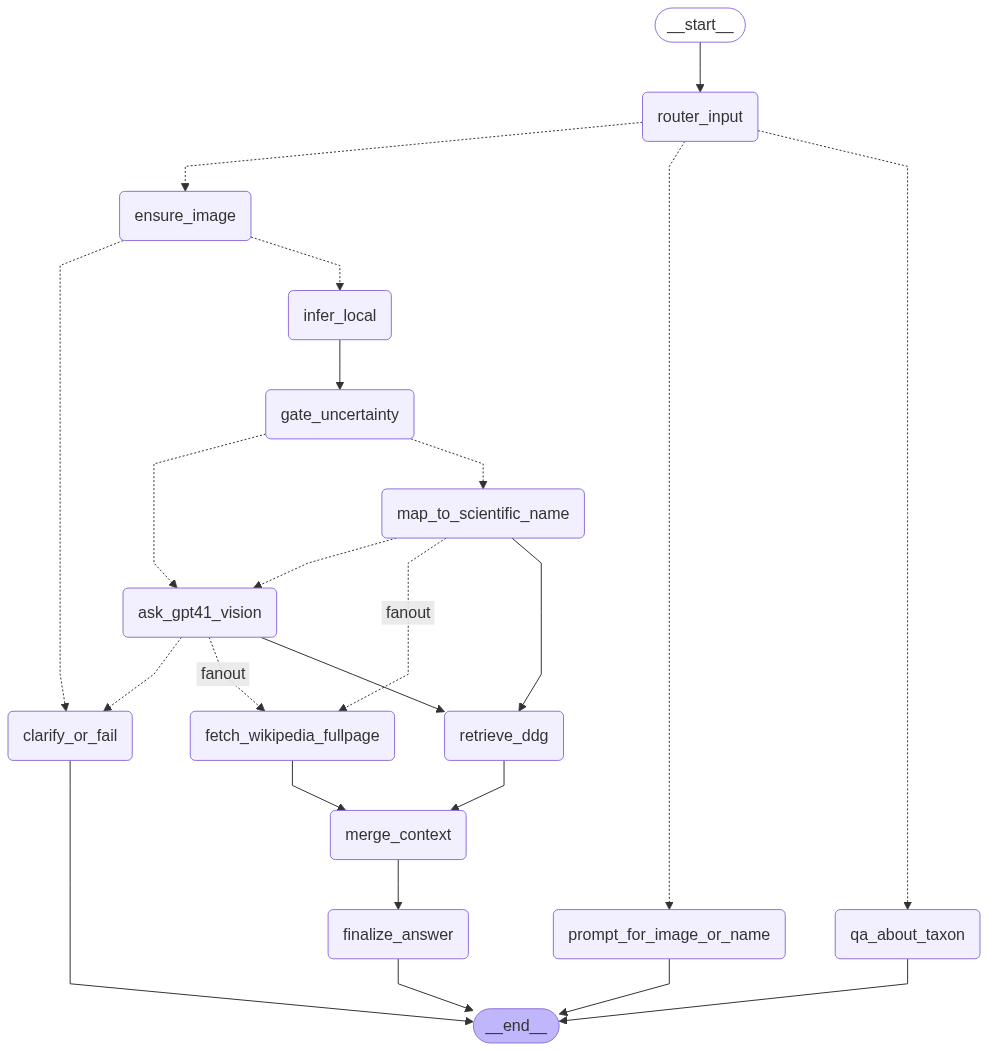

In [3]:
from IPython.display import Image, display

display(Image(compilado.get_graph().draw_mermaid_png()))